In [5]:
!pip3 install torch torchvision


In [0]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split


In [61]:
train = pd.read_csv(r"/content/train.csv",dtype = np.float32)
print (train.columns[:]) 
print(train.shape)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
(42000, 785)


In [0]:

# split data into features(pixels) and labels(numbers from 0 to 9)
label = train.label.values
# normalization
img  = train.loc[:,train.columns != "label"].values/255
# split train & val
img_train, img_val, label_train, label_val = train_test_split(img,label,test_size=0.2,
                                                                              random_state=42)
img_train = torch.from_numpy(img_train)
img_val = torch.from_numpy(img_val)

label_train = torch.from_numpy(label_train).type(torch.LongTensor) 
label_val = torch.from_numpy(label_val).type(torch.LongTensor)

traindata = torch.utils.data.TensorDataset(img_train,label_train)
valdata = torch.utils.data.TensorDataset(img_val,label_val)

batch_size = 100
train_loader = torch.utils.data.DataLoader(traindata, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(valdata, batch_size = batch_size, shuffle = False)

In [37]:
# visualize one of the images in data set
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([100, 784])
torch.Size([100])


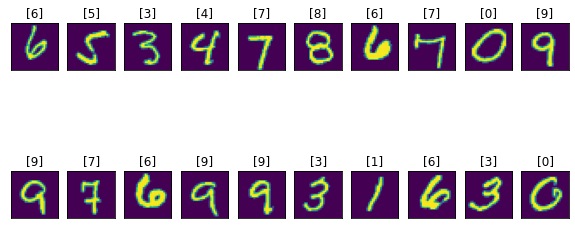

In [46]:
fig = plt.figure(figsize=(10,5))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(images[idx].reshape(28,28))
  ax.set_title([labels[idx].item()])

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10) 


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
       

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

In [97]:
epochs = 50
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for images, labels in train_loader:
    inputs = Variable(images.view(-1,1,28,28))
    labels = Variable(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_images, val_labels in val_loader:
        val_inputs = Variable(val_images.view(-1,1,28,28))
        val_labels = Variable(val_labels)
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = running_corrects.float()/ len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(val_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch : 1
training loss: 0.0071, acc 0.7777 
validation loss: 0.0029, validation acc 0.9130 
epoch : 2
training loss: 0.0024, acc 0.9290 
validation loss: 0.0021, validation acc 0.9349 
epoch : 3
training loss: 0.0018, acc 0.9446 
validation loss: 0.0016, validation acc 0.9515 
epoch : 4
training loss: 0.0016, acc 0.9516 
validation loss: 0.0016, validation acc 0.9537 
epoch : 5
training loss: 0.0014, acc 0.9579 
validation loss: 0.0014, validation acc 0.9570 
epoch : 6
training loss: 0.0013, acc 0.9610 
validation loss: 0.0013, validation acc 0.9642 
epoch : 7
training loss: 0.0012, acc 0.9639 
validation loss: 0.0013, validation acc 0.9626 
epoch : 8
training loss: 0.0011, acc 0.9669 
validation loss: 0.0013, validation acc 0.9648 
epoch : 9
training loss: 0.0011, acc 0.9653 
validation loss: 0.0012, validation acc 0.9635 
epoch : 10
training loss: 0.0010, acc 0.9680 
validation loss: 0.0012, validation acc 0.9656 
epoch : 11
training loss: 0.0010, acc 0.9692 
validation loss: 0.0011

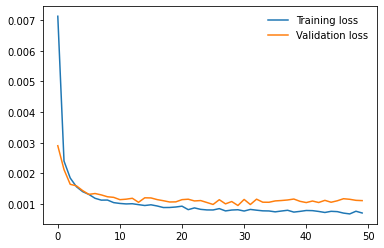

In [98]:
plt.plot(running_loss_history, label='Training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend(frameon=False)

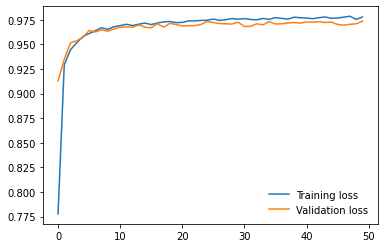

In [99]:
plt.plot(running_corrects_history, label='Training acc')
plt.plot(val_running_corrects_history, label='Validation acc')
plt.legend(frameon=False)

In [0]:
test = pd.read_csv(r"/content/test.csv",dtype = np.float32)
test_image = test.loc[:,test.columns != "label"].values/255
test_dataset = torch.from_numpy(test_image)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)

In [104]:
results = []

with torch.no_grad():
    model.eval()
    for images in test_loader:
        test = Variable(images.view(-1,1,28,28))
        test = test.to(device)
        output = model(test)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        results += top_class.cpu().numpy().tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
predictions = np.array(results).flatten()


In [111]:
predictions

array([2, 0, 9, ..., 3, 9, 2])

In [0]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("my_submissions.csv", index=False, header=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


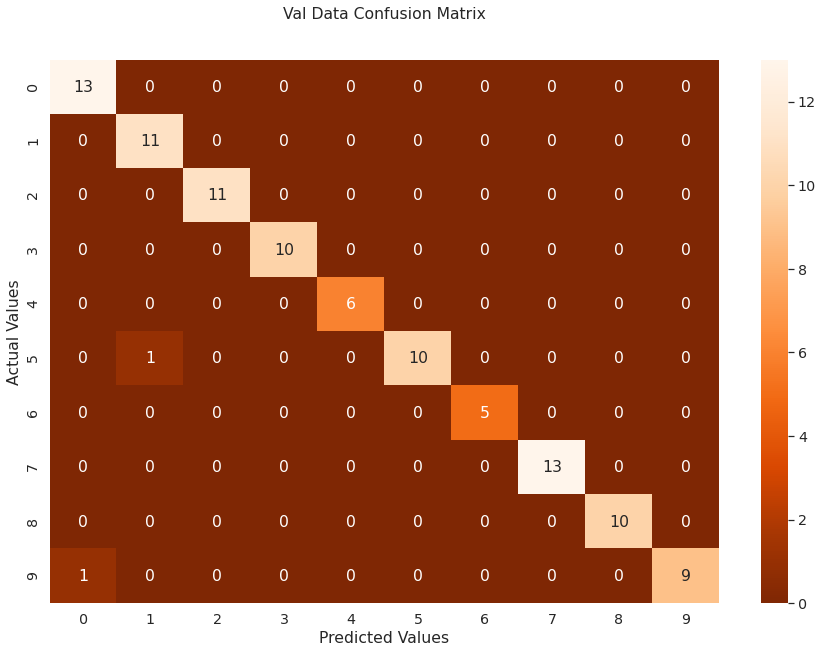

In [122]:
# Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
with torch.no_grad():
    model.eval()
    for images, labels in val_loader:
        x = Variable(images.view(-1,1,28,28))
        x = x.to(device)
        output = model(x)
        _, pred = torch.max(output, 1)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.3)
sns.heatmap(confusion_matrix(labels,pred.cpu()), annot = True, fmt = '.0f', cmap = 'Oranges_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Val Data Confusion Matrix\n\n')
plt.show()